<a href="https://colab.research.google.com/github/PaoloSani/SASP-Project/blob/First-attempt/Speech_dereverberation_using_Cepstrum_alanysis_cla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import IPython.display as ipd
from scipy.signal import find_peaks

plt.style.use('seaborn')

# **Load the clean voice recording and the IR**




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd "/content/drive/MyDrive/SASP Project"
%ls

# path to the folder in drive
path = "/content/drive/MyDrive/SASP Project"

voice, Fs = librosa.load(path + "/singing.wav", sr=None)
ir, Fs_ir = librosa.load(path + "/spokane_womans_club_ir.wav", sr=None, mono=False)

ipd.display(ipd.Audio(voice, rate=Fs))

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1GzKc7ODEHb4mh8TUbTFozamNCefDjAO9/SASP Project
reverbered_voice.wav  singing.wav  spokane_womans_club_ir.wav


In [ ]:
# Synthesize sinusoidal signal 

t_end = int(np.ceil(1.5*Fs))
time = np.arange(0,t_end)/Fs

sinusoid = np.sin(440*time)
sinusoid = 10*sinusoid[0:t_end]
# plt.plot(time, sinusoid);  

# **Create the new reverbered audio**

In [ ]:
signal_dry = voice[0:t_end]     # shorten the original audio file

In [ ]:
ipd.display(ipd.Audio(signal_dry, rate=Fs))
ipd.display(ipd.Audio(sinusoid, rate=Fs))

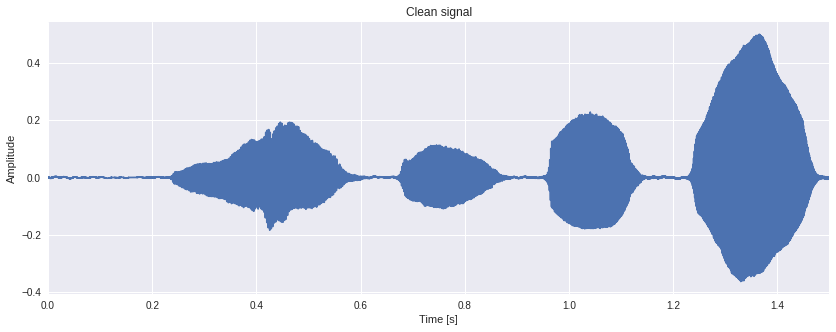

In [ ]:
signal_dry_length = signal_dry.shape[-1]
t_instants = np.arange(0,signal_dry_length) / Fs
final_duration = signal_dry_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,signal_dry)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Clean signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [ ]:
signal_wet = np.array([np.convolve(signal_dry, ir[0,:]),
              np.convolve(signal_dry, ir[1,:])]).T

# signal_wet = np.array([np.convolve(sinusoid, ir[0,:]),
#                np.convolve(sinusoid, ir[1,:])]).T

# normalize the obtained audio
signal_wet = signal_wet / np.max(signal_wet)

# shorten the file 
t_end = int(np.ceil(4.4*Fs))
signal_wet = signal_wet[0:t_end]
signal_wet.shape 


(211201, 2)

In [ ]:
ipd.display(ipd.Audio(signal_wet.T, rate=Fs))

Finally, save the new reverbered file:


In [ ]:
import soundfile as sf
sf.write(path+"/reverbered_voice.wav", signal_wet, samplerate=Fs)

# **Process the audio file**

In [ ]:
# load the audio file (as MONO)
signal, Fs = librosa.load(path + "/reverbered_voice.wav", sr=None)

ipd.display(ipd.Audio(signal, rate=Fs))

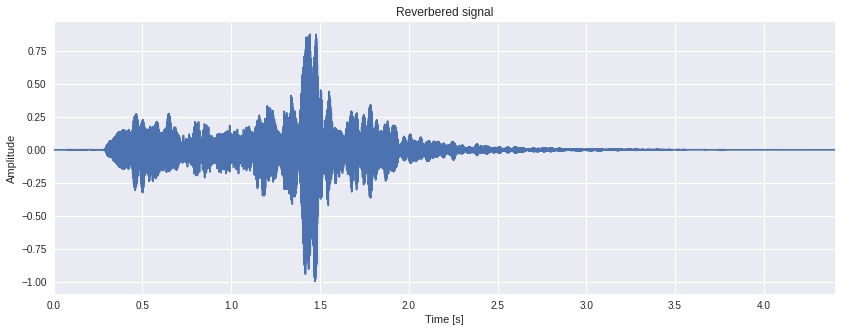

In [ ]:
signal_length = len(signal)

t_instants = np.arange(0,signal_length) / Fs
final_duration = signal_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,signal)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Reverbered signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

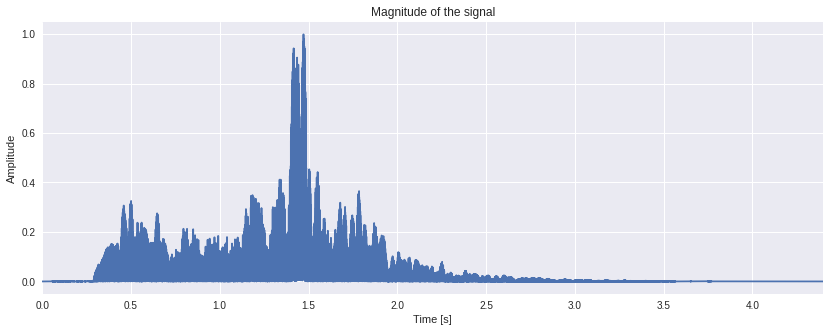

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(t_instants,np.abs(signal))
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Magnitude of the signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [ ]:
# SEGMENTATION by eye
segments = np.vstack([[0.23, 0.62],
            [0.66, 0.89],
            [0.95, 1.15],
            [1.22, 1.5]])
segments[:,0]


array([0.23, 0.66, 0.95, 1.22])

In [ ]:
# auxiliary function
def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

In [ ]:
limits_idx = np.zeros((4,2))

start_idx = (segments[:,0]*Fs).astype(int)
stop_idx = (segments[:,1]*Fs).astype(int)
limits_idx = np.vstack([start_idx, stop_idx])
print(limits_idx) 

durations = (limits_idx[1,:] - limits_idx[0,:])

durations = list(map(nextpow2, durations))
print(durations)

max_frame_size = np.max(durations);

frames = np.zeros((4,max_frame_size));
limits_idx[1,:] = limits_idx[0,:] + durations;


[[11040 31680 45600 58560]
 [29760 42720 55199 72000]]
[32768, 16384, 16384, 16384]


(4, 32768)
(4, 32768)
(4, 32768)
(4, 32768)


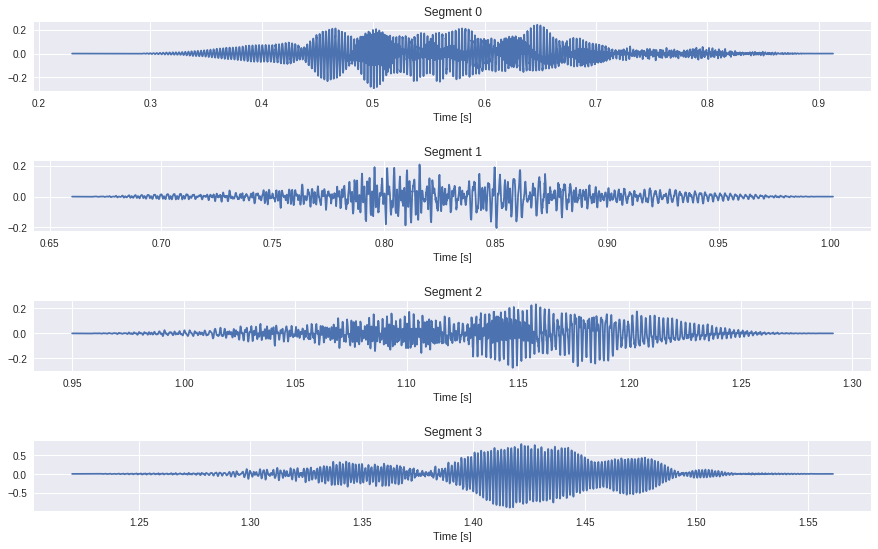

In [ ]:
plt.figure(figsize=(15,9))
for i in range(len(segments)):
  plt.subplot(4,1,i+1);

  t = t_instants[limits_idx[0,i] : limits_idx[1,i]];
  frame = signal[limits_idx[0,i] : limits_idx[1,i]];
  print(frames.shape)
  frames[i, 0:durations[i]] = frame;

  win = np.hanning(frame.shape[0])
  frame = win*frame
  # TODO: exponential window + exponential weighting

  plt.plot(t, frame)
  plt.xlabel('Time [s]')
  plt.title('Segment {}' .format(i))
  plt.subplots_adjust(hspace=1)
  plt.subplots_adjust(wspace = 0.5)

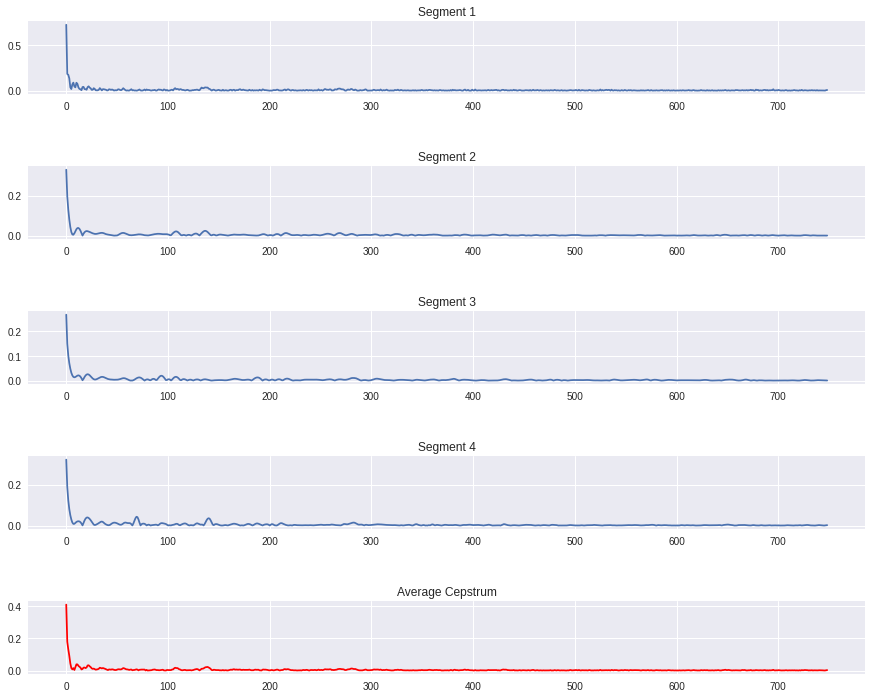

In [ ]:
max_quefrency_bin = 150
avg_Cepstrum = np.zeros((4, 5*max_quefrency_bin-1), dtype = 'complex_')

plt.figure(figsize=(15,12))
for i in range(len(segments)):
  plt.subplot(5,1,i+1);

  segm = frames[i,:]
  X = np.fft.fft(segm, n=None, axis=0)
  magnitude = np.abs(X)
  unwrapped_phase = np.unwrap(np.angle(X))
  real_X = np.real(X)
  L = len(X)
  freq = np.fft.fftfreq(L, d=Fs/L)

  # Compute complex Cepstrum
  log_abs = np.log10(magnitude)
  log_phase = unwrapped_phase*np.log10(np.e)
  log_spectrum = log_abs + 1j*log_phase

  Cepstrum_real = np.fft.ifft(log_abs)
  Cepstrum_real = Cepstrum_real[1:5*max_quefrency_bin]
  quefrency = range(len(Cepstrum_real));
  plt.plot(quefrency, np.abs(Cepstrum_real))

  avg_Cepstrum[i,:] = Cepstrum_real;
  plt.title("Segment {}" .format(i+1));

avg_Cepstrum = np.sum(avg_Cepstrum,0)/len(segments);
plt.subplot(5,1,5)
plt.plot(quefrency, np.abs(avg_Cepstrum), 'r');
plt.title("Average Cepstrum");
plt.subplots_adjust(hspace=1)
plt.subplots_adjust(wspace = 0.5)

[  7  10  18  22  27  33  36  56 107 109 139 269 280]


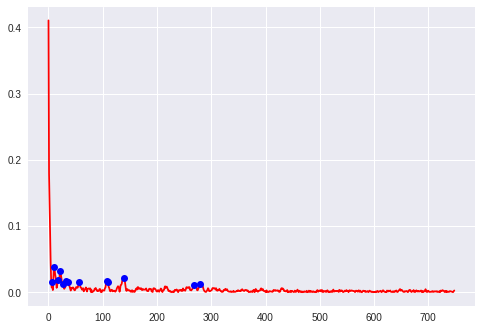

In [ ]:
# PEAK DETECTION
threshold = [0.01, 0.2] # per il momento a caso
peaks, _ = find_peaks(abs(avg_Cepstrum), height=threshold)
print(peaks)

plt.plot(quefrency, np.abs(avg_Cepstrum), 'r')
plt.plot(peaks,np.abs(avg_Cepstrum[peaks]),'bo')
plt.show;

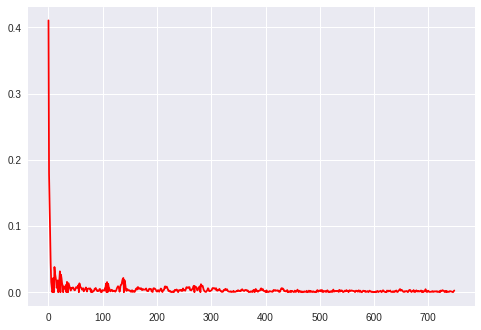

In [ ]:
# INVERSE LIFTERING
avg_Cepstrum[peaks] = 0.0
plt.plot(quefrency, np.abs(avg_Cepstrum), 'r');

In [ ]:
# GO BACK TO ORIGINAL SIGNAL
log_spectrum_liftered = np.fft.fft(avg_Cepstrum)
freq_rec = 
spectrum_liftered = 10^log_spectrum_liftered
signal_liftered = np.fft.ifft(spectrum_liftered)
